In [1]:
import numpy as np
import numpy.random as nrd
import numpy.linalg as nla

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

# Exercise 13.8

Generate data in two classes, with two features. These features
are all independent Gaussian variates with standard deviation 1. Their
mean vectors are (−1,−1) in class 1 and (1, 1) in class 2. To each feature
vector apply a random rotation of angle θ, θ chosen uniformly from 0 to
2π. Generate 50 observations from each class to form the training set, and
500 in each class as the test set. Apply four different classifiers:

1. Nearest-neighbors.
2. Nearest-neighbors with hints: ten randomly rotated versions of each data point are added to the training set before applying nearest-neighbors.
3. Invariant metric nearest-neighbors, using Euclidean distance invariant to rotations about the origin.
4. Tangent distance nearest-neighbors.

In each case choose the number of neighbors by tenfold cross-validation.
Compare the results.

# Solution

Data generation,

In [2]:
# generate data from independent gaussian dists at different mean for each class
def data_generation(N,mu1,mu2,R):
    
    class1 = nrd.normal(loc=mu1, size=(N//2,p))
    class2 = nrd.normal(loc=mu2, size=(N//2,p))
    
    # Input data (with random rotations)
    X = np.concatenate((class1,class2))
    for i in range(N):
        theta = 2*np.pi*nrd.rand()
        X[i] = R(theta) @ X[i]
    
    # Response
    y = np.zeros(N)
    y[N//2:] = 1
    
    return X,y

In [3]:
p = 2
N_train = 100
N_test = 1000

# Centres of Gaussian distribution
mu1 = np.array([-1,-1])
mu2 = np.array([1,1])

# Rotation matrix
R = lambda t : np.array([[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]])

# Train and test sets
X,y = data_generation(N_train,mu1,mu2,R)
X_test,y_test = data_generation(N_test,mu1,mu2,R)

Let's visualize the training set,

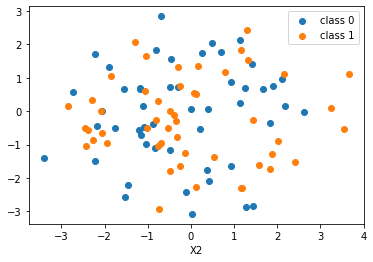

In [4]:
plt.scatter(X[:N_train//2,0],X[:N_train//2,1],label='class 0')
plt.scatter(X[N_train//2:,0],X[N_train//2:,1],label='class 1')
plt.xlabel('X1')
plt.xlabel('X2')
plt.legend()
plt.show()

Since the mean vectors are at the same distance from the origin, th random rotation is messing up the dataset quite substantially.

## Classification

Some useful functions for later,

In [5]:
# returns cross-validaiton split
def cross_validation_split(X,y,K):
    N,_ = X.shape
    delta = N//K
    
    data_CV = []
    
    for i in range(K):
        
        X_train = np.concatenate((X[:i*delta],X[(i+1)*delta:]))
        y_train = np.concatenate((y[:i*delta],y[(i+1)*delta:]))
        
        X_val = X[i*delta:(i+1)*delta]
        y_val = y[i*delta:(i+1)*delta]
        
        data_CV.append((X_train,y_train,X_val,y_val))
        
    return data_CV

# Compute misclassification error and std_error
def misclass_error(y,y_predict):
    return np.mean(y != y_predict)

# Add hints to dataset
def generate_hints(X,y,hint_number=10):
    
    X_hint = []
    y_hint = []
    
    for x,y in zip(X,y):
        for _ in range(hint_number):
            theta = 2*np.pi*nrd.rand()
            X_hint.append(R(theta) @ x)
            y_hint.append(y)
            
    return np.array(X_hint), np.array(y_hint)

# Cross-validation for a given model wrt a list of parameters
def cross_validation_plot(X,y,num_nn,classifier,dist='minkowski',K=10):

    error_train = []
    error_val = []
    std_err_val = []

    for num in num_nn:
        misclass_error_train = []
        misclass_error_val = []
        for X_train,y_train,X_val,y_val in cross_validation_split(X,y,K):

            # Train model
            model = classifier(n_neighbors=num,metric=dist)
            model.fit(X_train,y_train)

            # Compute training error
            y_predict_train = model.predict(X_train)
            err_train = misclass_error(y_train,y_predict_train)
            misclass_error_train.append(err_train)

            # Compute validation error
            y_predict_val = model.predict(X_val)
            err_val = misclass_error(y_val,y_predict_val)
            misclass_error_val.append(err_val)

        error_train.append(np.mean(misclass_error_train))
        error_val.append(np.mean(misclass_error_val))
        std_err_val.append(np.std(misclass_error_val)/np.sqrt(K))

    # Plot the cross-validaiton curve
    plt.plot(num_nn,error_train,label='train error')
    plt.errorbar(num_nn,error_val,yerr=std_err_val,label='val error')
    plt.xlabel('number of neighbors')
    plt.ylabel('misclass error')
    plt.grid()
    plt.legend()
    plt.show()
    
# Radial distance
def radial_distance(x1,x2):
    return abs(nla.norm(x1) - nla.norm(x2))

### Nearest-Neighbours

Let's use cross-validation to estimate the best number of neighbours,

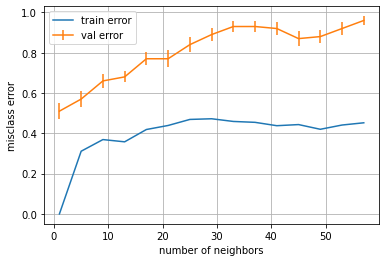

In [6]:
# list of possible numbe of neigbours
number_neigbours = list(range(1,60,4))

# classifier
classifier = KNeighborsClassifier

cross_validation_plot(X,y,number_neigbours,classifier)

Using one-std-err rule, we should go for 1 nn. Also, our model is doing worse that just randomly guess what the class is, but given how the dataset was design, I doubt we could get any better that 50/50!

In [7]:
num_opt = 1

# Train model
model = KNeighborsClassifier(n_neighbors=num_opt)
model.fit(X,y)

# Get test error
y_predict = model.predict(X_test)
err_test = misclass_error(y_test,y_predict)

print('1-NN classifier get test error = {:.3f}'.format(err_test))

1-NN classifier get test error = 0.503


### Nearest-neighbors with hints

We generate ten randomly rotated versions of each data point and add them to the training set before applying nearest-neighbors.

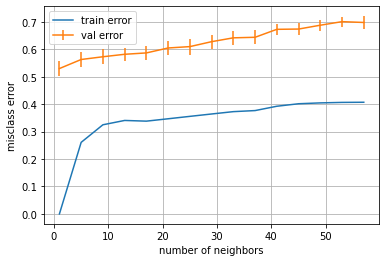

In [8]:
# Dataset with hints
X_hint, y_hint = generate_hints(X,y)

# list of possible number of neigbours
number_neigbours = list(range(1,60,4))

# classifier
classifier = KNeighborsClassifier

cross_validation_plot(X_hint, y_hint,number_neigbours,classifier)

Again, the one-std-error suggests 1-NN, and we already know the outcome on the test set.

### Nearest Neighbours with invariant metric

The invariant metric is the euclidian one with respect to radial coordinates

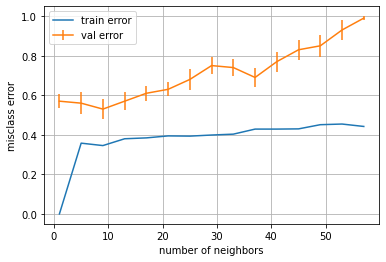

In [9]:
# list of possible numbe of neigbours
number_neigbours = list(range(1,60,4))

# classifier
classifier = KNeighborsClassifier

cross_validation_plot(X,y,number_neigbours,classifier,dist=radial_distance)

The one-std-err rule again suggests to use 1-NN with the radial distance,

In [10]:
num_opt = 1

# Train model
model = KNeighborsClassifier(n_neighbors=num_opt,metric=radial_distance)
model.fit(X,y)

# Get test error
y_predict = model.predict(X_test)
err_test = misclass_error(y_test,y_predict)

print('1-NN classifier get test error = {:.3f}'.format(err_test))

1-NN classifier get test error = 0.500


### Tangent distance nearest-neighbors

Not sure this is helpful here, since the space is 2 dimensional and almost all tangents will intercept, giving distance 0!